## Diabetes Predicion Based on Health Survey - Reduced Models for deployment

In this notebooks are trained reduced models over a filtered dataset of the important variables selected, it is also trained over feature names edited to improve variables understanding over inference. On the EDA and initial model training it was discover a lot of features not originally surveyed but derived from the original variables, so it was identified a lot of correlated varibles reporting the same in different ways, also it was found a lot of not informative variables for the task in hand

In [52]:
import pandas as pd
import gzip
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

In [24]:
# warnings.filterwarnings("ignore")
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
# visibility of columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
df = pd.read_csv('../data/df_train.csv')
df.shape

(67136, 22)

In [9]:
df_train.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1,0.0,1,33.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,15.0,0.0,1.0,1,7,6.0,9.0
1,0.0,0,1.0,1,27.0,1.0,0.0,0.0,1,0,...,1,0.0,2.0,1.0,2.0,0.0,1,7,6.0,6.0
2,0.0,0,1.0,1,26.0,1.0,0.0,0.0,0,0,...,1,0.0,3.0,0.0,30.0,0.0,1,13,4.0,3.0
3,0.0,0,0.0,1,19.0,1.0,0.0,0.0,1,1,...,1,0.0,3.0,0.0,0.0,0.0,0,11,5.0,7.0
4,0.0,1,0.0,1,37.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,0.0,0.0,0.0,0,5,5.0,3.0


In [10]:
target = "Diabetes_binary"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (67136, 21)
y shape: (67136,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (53708, 21)
y_train shape: (53708,)
X_test shape: (13428, 21)
y_test shape: (13428,)


<Axes: xlabel='Diabetes_binary'>

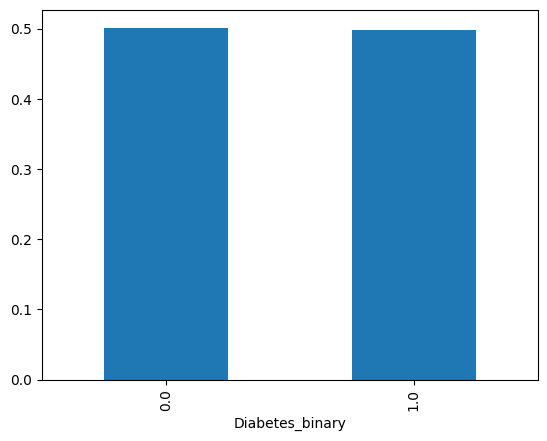

In [13]:
y_train.value_counts(normalize=True).plot(kind="bar")

In [14]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5019


In [15]:
clf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [17]:
cv_acc_scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.7269596  0.73198659 0.73049711 0.73307886 0.73484778]


In [18]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__max_depth": range(10, 50, 10),
    "randomforestclassifier__n_estimators": range(25, 100, 25) 
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__max_depth': range(10, 50, 10),
 'randomforestclassifier__n_estimators': range(25, 100, 25)}

In [19]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [22]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [35]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.037401,0.164594,0.182759,0.061137,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.740923,0.745113,0.742878,0.742668,0.743692,0.743055,0.001369,5
1,2.231800,0.159261,0.155714,0.023720,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.740923,0.745113,0.742878,0.742668,0.743692,0.743055,0.001369,5
2,4.020223,0.548155,0.311328,0.022072,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.741761,0.747347,0.741296,0.743506,0.744530,0.743688,0.002171,3
3,4.546008,0.157317,0.231399,0.023059,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.741761,0.747347,0.741296,0.743506,0.744530,0.743688,0.002171,3
4,6.100298,0.312643,0.340139,0.053179,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.741854,0.748185,0.741110,0.744437,0.746113,0.744340,0.002629,1
5,6.096091,0.362855,0.351127,0.060994,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.741854,0.748185,0.741110,0.744437,0.746113,0.744340,0.002629,1
6,3.042310,0.279703,0.192353,0.017398,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.730032,0.738131,0.729845,0.737734,0.736430,0.734434,0.003714,11
7,3.338792,0.161159,0.211074,0.039669,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.730032,0.738131,0.729845,0.737734,0.736430,0.734434,0.003714,11
8,5.939080,0.409797,0.397061,0.036232,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.734500,0.738131,0.731987,0.740899,0.737734,0.736650,0.003092,9
9,6.185118,0.348860,0.406040,0.087334,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.734500,0.738131,0.731987,0.740899,0.737734,0.736650,0.003092,9


In [26]:
cv_results.loc[4:5, ['params', 'mean_test_score']]

,params,mean_test_score
4,"{'randomforestclassifier__max_depth': 10, 'ran...",0.74434
5,"{'randomforestclassifier__max_depth': 10, 'ran...",0.74434


In [32]:
cv_results.loc[4:5, ['params', 'mean_test_score']].loc[4, 'params']

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'mean'}

In [33]:
cv_results.loc[4:5, ['params', 'mean_test_score']].loc[5, 'params']

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'median'}

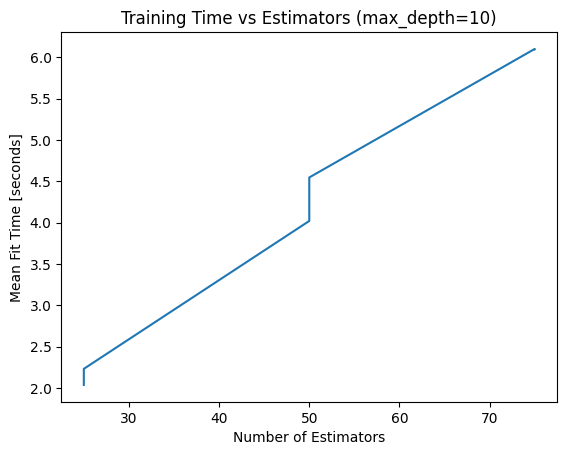

In [34]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

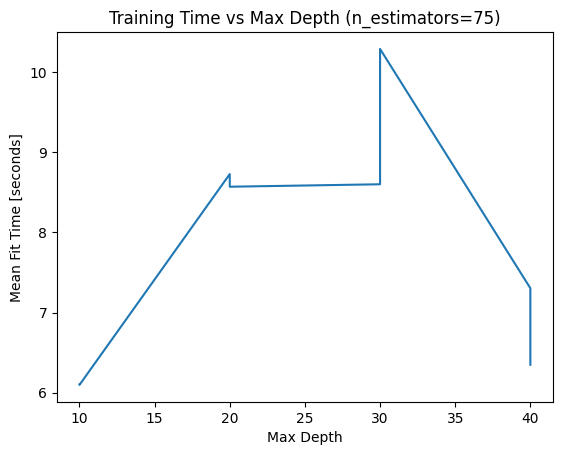

In [36]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 75
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]

)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=75)");

In [37]:
model.best_score_

0.7443397979934481

In [38]:
# Extract best hyperparameters
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=75,
                                        random_state=42))])

In [39]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.7678
Test Accuracy: 0.7414


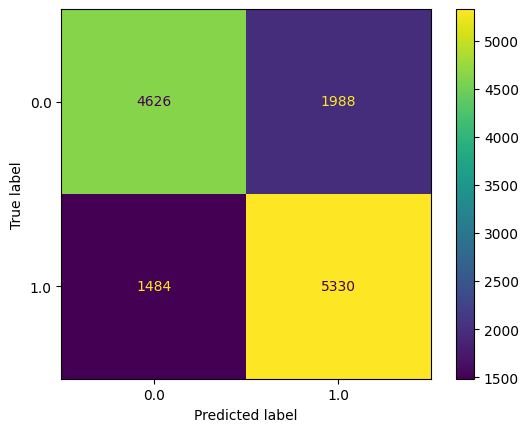

In [40]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

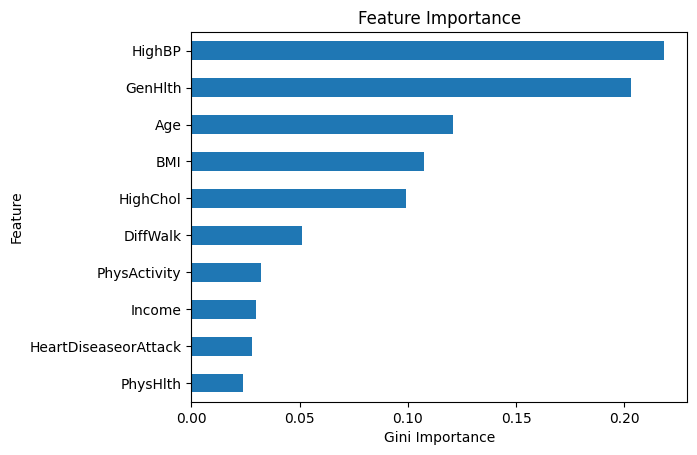

In [42]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [43]:
# Save model
with open("../models/model_rf.pkl", "wb") as f:
    pickle.dump(model, f)

In [53]:
clf = make_pipeline(
    SimpleImputer(),
    GradientBoostingClassifier()
)
clf

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [54]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__max_depth": range(2, 5),
    "gradientboostingclassifier__n_estimators": range(20, 31, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__max_depth': range(2, 5),
 'gradientboostingclassifier__n_estimators': range(20, 31, 5)}

In [55]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [56]:
# Fit model to over-sampled training data
model.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [57]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,3.399816,0.573390,0.019664,0.000328,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.739434,0.743437,0.740086,0.743506,0.745089,0.742310,0.002175,1
16,4.169356,0.340530,0.026918,0.002637,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.739434,0.743437,0.740086,0.743506,0.745089,0.742310,0.002175,1
11,4.363384,0.456865,0.036499,0.006498,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.739062,0.743158,0.737293,0.742203,0.744623,0.741268,0.002697,3
10,4.039262,0.372493,0.031680,0.006655,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.739062,0.743158,0.737293,0.742203,0.744623,0.741268,0.002697,3
15,4.290723,0.261009,0.030146,0.005685,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.738224,0.743623,0.739899,0.742575,0.742017,0.741268,0.001947,5
14,4.460074,0.361322,0.036684,0.015701,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.738224,0.743623,0.739899,0.742575,0.742017,0.741268,0.001947,5
9,3.620672,0.221869,0.037437,0.010299,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.738969,0.740458,0.737293,0.741272,0.741830,0.739964,0.001647,7
8,3.379950,0.251605,0.028873,0.004567,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.738969,0.740458,0.737293,0.741272,0.741830,0.739964,0.001647,7
12,3.688954,0.388511,0.032130,0.011716,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.737758,0.740644,0.737851,0.741737,0.738944,0.739387,0.001569,9
13,4.007536,0.145901,0.032047,0.003677,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.737758,0.740644,0.737851,0.741737,0.738944,0.739387,0.001569,9


In [58]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

In [59]:
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, n_estimators=30))])

In [60]:
model.best_score_

0.7423103443511987

In [61]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.7477
Validation Accuracy: 0.7429


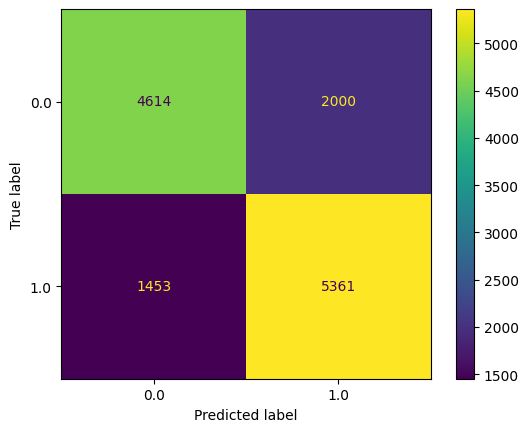

In [62]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [63]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      6614
         1.0       0.73      0.79      0.76      6814

    accuracy                           0.74     13428
   macro avg       0.74      0.74      0.74     13428
weighted avg       0.74      0.74      0.74     13428



In [64]:
# Save model
with open("../models/model_gbc.pkl", "wb") as f:
    pickle.dump(model, f)

In [67]:
X_train.iloc[1,:].to_dict()

{'HighBP': 1.0,
 'HighChol': 1.0,
 'CholCheck': 1.0,
 'BMI': 35.0,
 'Smoker': 0.0,
 'Stroke': 0.0,
 'HeartDiseaseorAttack': 0.0,
 'PhysActivity': 1.0,
 'Fruits': 0.0,
 'Veggies': 1.0,
 'HvyAlcoholConsump': 1.0,
 'AnyHealthcare': 1.0,
 'NoDocbcCost': 0.0,
 'GenHlth': 2.0,
 'MentHlth': 0.0,
 'PhysHlth': 0.0,
 'DiffWalk': 0.0,
 'Sex': 1.0,
 'Age': 5.0,
 'Education': 4.0,
 'Income': 9.0}